In [1]:
!pip install xmltodict
import xmltodict

In [2]:
!git clone https://github.com/fizyr/keras-retinanet.git

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 5736 (delta 12), reused 14 (delta 5), pack-reused 5705
Receiving objects: 100% (5736/5736), 13.37 MiB | 23.82 MiB/s, done.
Resolving deltas: 100% (3843/3843), done.


In [3]:
%cd keras-retinanet/

!pip install .

/content/keras-retinanet
Processing /content/keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-0.5.1-cp36-cp36m-linux_x86_64.whl size=169030 sha256=6d1b79765bda9fb18d56a91316a7c290f5afc2aad26d5951ac116cd686b6b663
  Stored in directory: /root/.cache/pip/wheels/b2/9f/57/cb0305f6f5a41fc3c11ad67b8cedfbe9127775b563337827ba
  Created wheel for keras-resnet: filename=keras_resnet-0.1.0-py2.py3-none-any.whl size=13346 sha256=269e18e50673a276e4c78531bc99455b036dcc575cc7a3c3d97dbcdc321c80e9
  Stored in directory: /root/.cache/pip/wheels/80/dd/ac/842235b63dddac12faa4b48ebe58b8944e8c2e57c2e38dddb6
Successfully built keras-retinanet keras-resnet


In [4]:
!python setup.py build_ext --inplace

running build_ext
cythoning keras_retinanet/utils/compute_overlap.pyx to keras_retinanet/utils/compute_overlap.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/keras-retinanet/keras_retinanet/utils/compute_overlap.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'keras_retinanet.utils.compute_overlap' extension
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/keras_retinanet
creating build/temp.linux-x86_64-3.6/keras_retinanet/utils
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.6m -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -c keras_retinanet/utils/compute_overlap.c -o build/temp.linux-x86_64-3.6/keras_retinanet/utils/compute_over

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
import urllib
import os
import csv
import cv2
import time
from PIL import Image

from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [7]:
CLASSES_FILE = '/content/drive/My Drive/Unreal_AI/classes.csv'
model_path = '/content/drive/My Drive/Unreal_AI/resnet50_csv_30.h5'
model = models.load_model(model_path, backbone_name='resnet50')
model = models.convert_model(model)
labels_to_names = pd.read_csv(CLASSES_FILE, header=None).T.loc[0].to_dict()

Using TensorFlow backend.


tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-22.627417, -11.313708,  22.627417,  11.313708],
       [-28.50876 , -14.25438 ,  28.50876 ,  14.25438 ],
       [-35.918785, -17.959393,  35.918785,  17.959393],
       [-16.      , -16.      ,  16.      ,  16.      ],
       [-20.158737, -20.158737,  20.158737,  20.158737],
       [-25.398417, -25.398417,  25.398417,  25.398417],
       [-11.313708, -22.627417,  11.313708,  22.627417],
       [-14.25438 , -28.50876 ,  14.25438 ,  28.50876 ],
       [-17.959393, -35.918785,  17.959393,  35.918785]], dtype=float32)> anchors
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-45.254833, -22.627417,  45.254833,  22.627417],
       [-57.01752 , -28.50876 ,  57.01752 ,  28.50876 ],
       [-71.83757 , -35.918785,  71.83757 ,  35.918785],
       [-32.      , -32.      ,  32.      ,  32.      ],
       [-40.317474, -40.317474,  40.317474,  40.317474],
       [-50.796833, -50.796833,  50.7

In [0]:
def predict(image):
  image = preprocess_image(image.copy())
  image, scale = resize_image(image)

  boxes, scores, labels = model.predict_on_batch(
    np.expand_dims(image, axis=0)
  )

  boxes /= scale

  return boxes, scores, labels

In [0]:
THRES_SCORE = 0.65

def draw_detections(image, boxes, scores, labels):
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
    if score < THRES_SCORE:
        break

    color = label_color(label)

    b = box.astype(int)
    draw_box(image, b, color=color)

    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(image, b, caption)

In [0]:
def show_detected_objects(image_row):
  img_path = image_row.image_name
  
  image = read_image_bgr(img_path)

  boxes, scores, labels = predict(image)

  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

  true_box = [
    image_row.x_min, image_row.y_min, image_row.x_max, image_row.y_max
  ]
  draw_box(draw, true_box, color=(255, 255, 0))

  draw_detections(draw, boxes, scores, labels)

  plt.axis('off')
  plt.figure(figsize=(15,15))
  plt.imshow(draw)
  plt.show()

In [0]:
def getImageNamestest():
    image_names = []
    for dirname, _, filenames in os.walk('/content/drive/My Drive/Unreal_AI/COVID-19/example'):
        for filename in filenames:
            fullpath = os.path.join(dirname, filename)
            extension = fullpath[len(fullpath) - 4:]
            if extension == '.png':
                image_names.append(filename)
    return image_names

def get_path_test(image_name):

  home_path = '/content/drive/My Drive/Unreal_AI/COVID-19/'
  image_path = home_path + 'example/' + image_name
    
  if image_name[-4:] == 'jpeg':
      label_name = image_name[:-5] + '.xml'
  else:
      label_name = image_name[:-4] + '.xml'
    
  label_path = home_path + 'example/' + label_name
        
  return  image_path, label_path

In [0]:
image_names_test = getImageNamestest()

In [13]:
dataset_test = dict()
dataset_test["image_name"] = list()
dataset_test["x_min"] = []
dataset_test["y_min"] = []
dataset_test["x_max"] = []
dataset_test["y_max"] = []
dataset_test["class_name"] = list()

for i in range (12):
  image_path, label_path = get_path_test(image_names_test[i])
  
  x = xmltodict.parse(open(label_path , 'rb'))
  print(i)
  item_list = x['annotation']['object']
  try:
    item_list1 = item_list['bndbox']['xmin']
    item_list2 = item_list['bndbox']['ymin']
    item_list3 = item_list['bndbox']['xmax']
    item_list4 = item_list['bndbox']['ymax']
    item_list5 = item_list['name']

    dataset_test["x_min"].append(int(item_list1))
    dataset_test["y_min"].append(int(item_list2))
    dataset_test["x_max"].append(int(item_list3))
    dataset_test["y_max"].append(int(item_list4))
    dataset_test["class_name"].append(item_list5)
    dataset_test["image_name"].append(image_path)

  except:
    for item in item_list:
      item_list1 = item['bndbox']['xmin']
      item_list2 = item['bndbox']['ymin']
      item_list3 = item['bndbox']['xmax']
      item_list4 = item['bndbox']['ymax']
      item_list5 = item['name']

      dataset_test["x_min"].append(int(item_list1))
      dataset_test["y_min"].append(int(item_list2))
      dataset_test["x_max"].append(int(item_list3))
      dataset_test["y_max"].append(int(item_list4))
      dataset_test["class_name"].append(item_list5)
      dataset_test["image_name"].append(image_path)

0
1
2
3
4
5
6
7
8
9
10
11


In [14]:
test_df = pd.DataFrame(dataset_test)
test_df

image_name  x_min  ...  y_max  class_name
0   /content/drive/My Drive/Unreal_AI/COVID-19/exa...    168  ...    618        face
1   /content/drive/My Drive/Unreal_AI/COVID-19/exa...    142  ...    649   face_mask
2   /content/drive/My Drive/Unreal_AI/COVID-19/exa...    141  ...    639   face_mask
3   /content/drive/My Drive/Unreal_AI/COVID-19/exa...    145  ...    631   face_mask
4   /content/drive/My Drive/Unreal_AI/COVID-19/exa...    143  ...    632   face_mask
5   /content/drive/My Drive/Unreal_AI/COVID-19/exa...    130  ...    650   face_mask
6   /content/drive/My Drive/Unreal_AI/COVID-19/exa...    115  ...    636   face_mask
7   /content/drive/My Drive/Unreal_AI/COVID-19/exa...    137  ...    667   face_mask
8   /content/drive/My Drive/Unreal_AI/COVID-19/exa...    127  ...    666   face_mask
9   /content/drive/My Drive/Unreal_AI/COVID-19/exa...    110  ...    656        face
10  /content/drive/My Drive/Unreal_AI/COVID-19/exa...    118  ...    647        face
11  /content/drive/My Drive/Unreal_AI/COVID-19/exa...    108  ...    679        face

[12 rows x 6 columns]

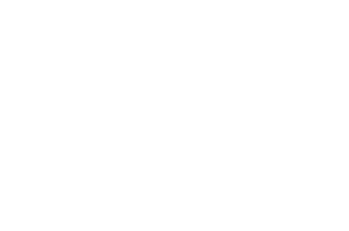

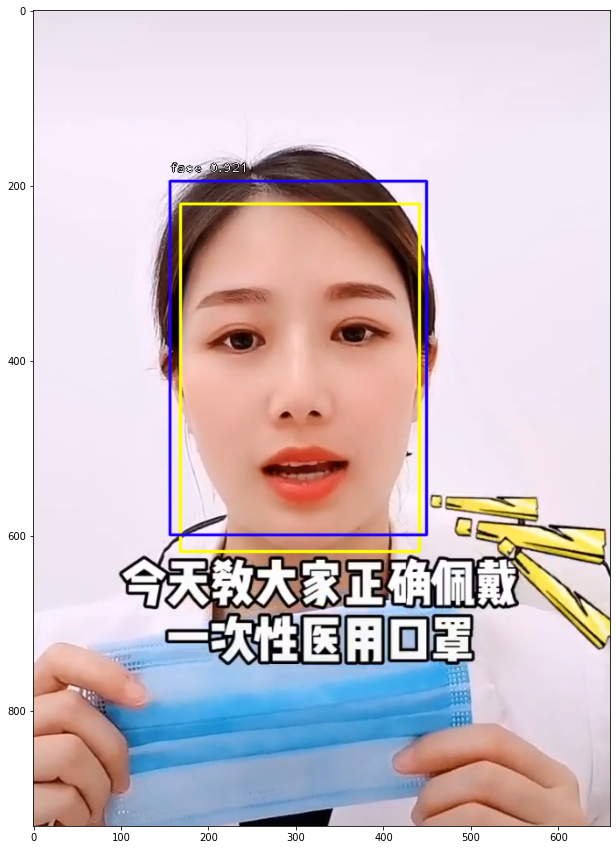

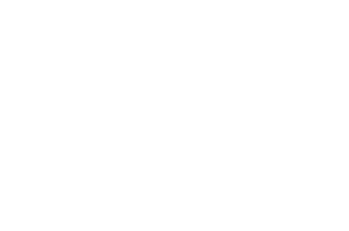

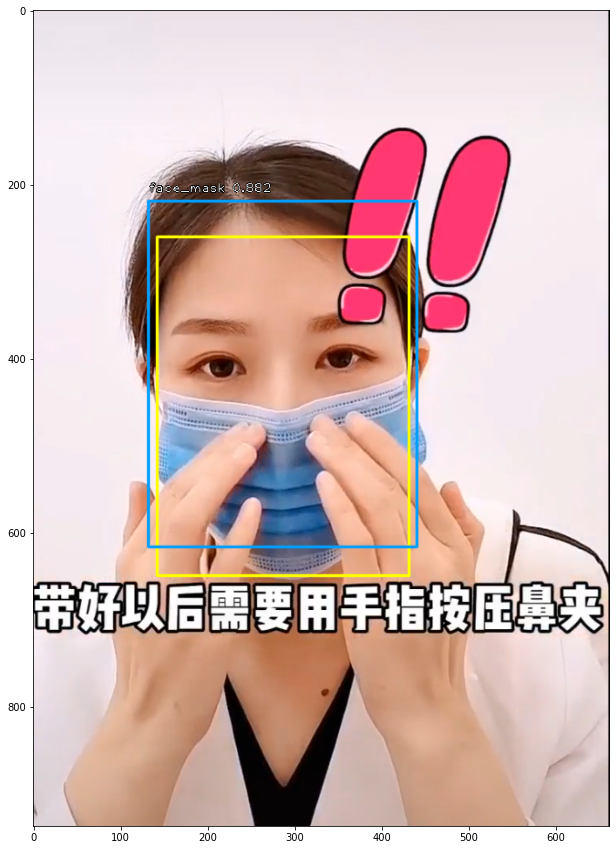

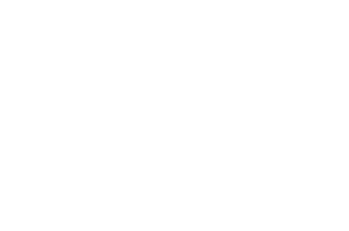

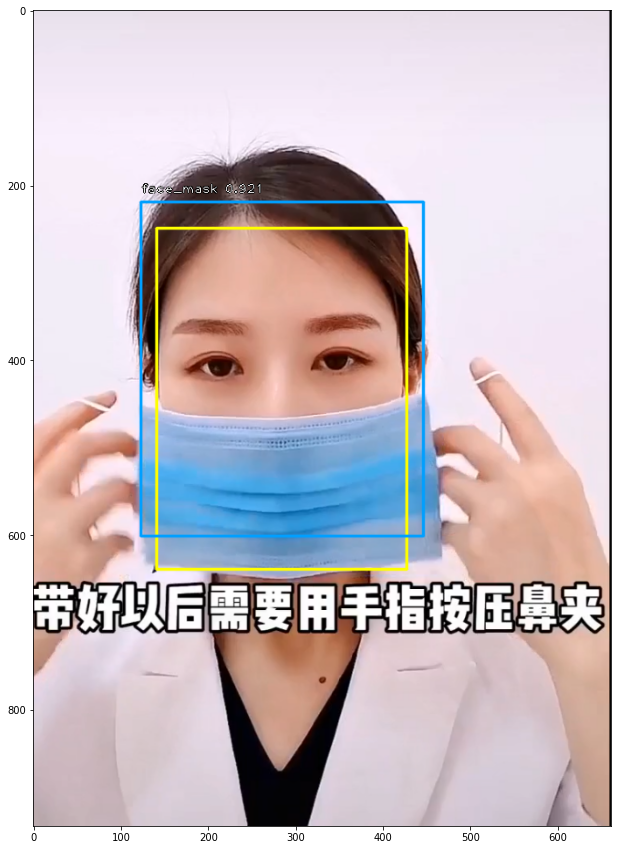

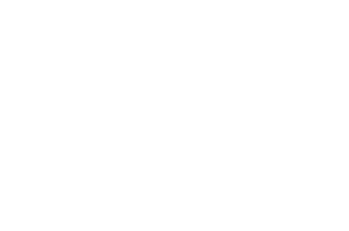

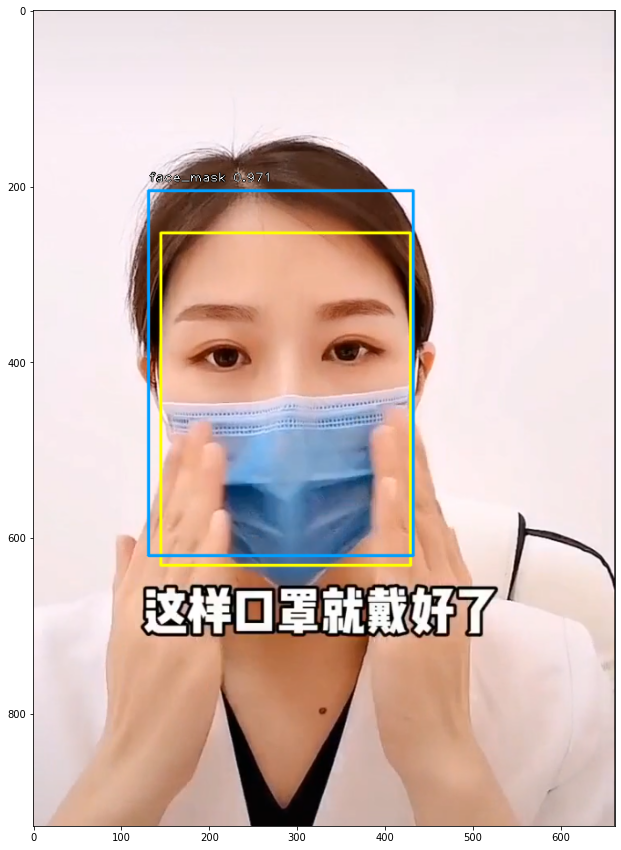

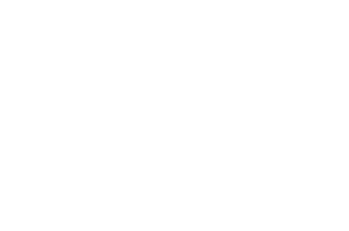

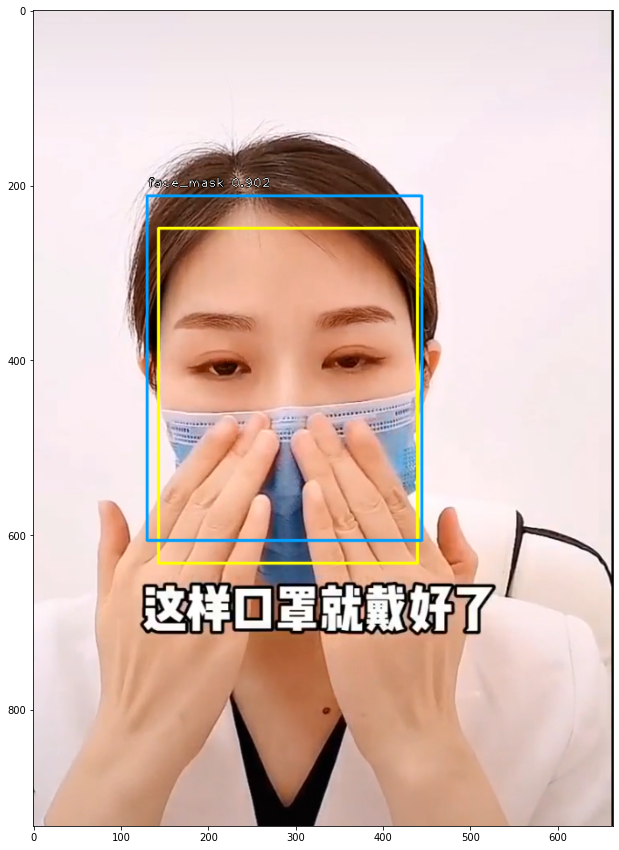

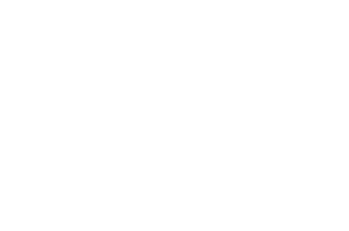

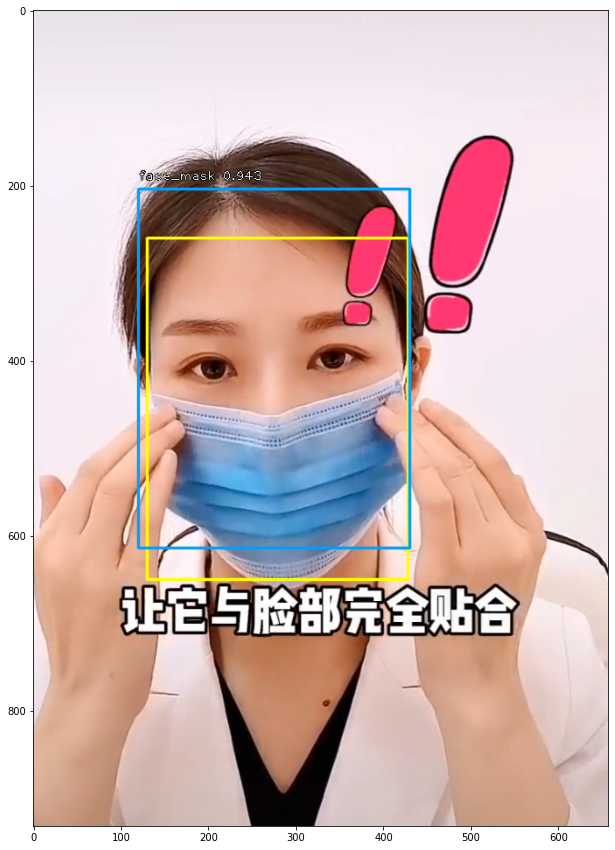

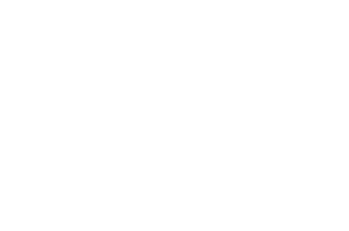

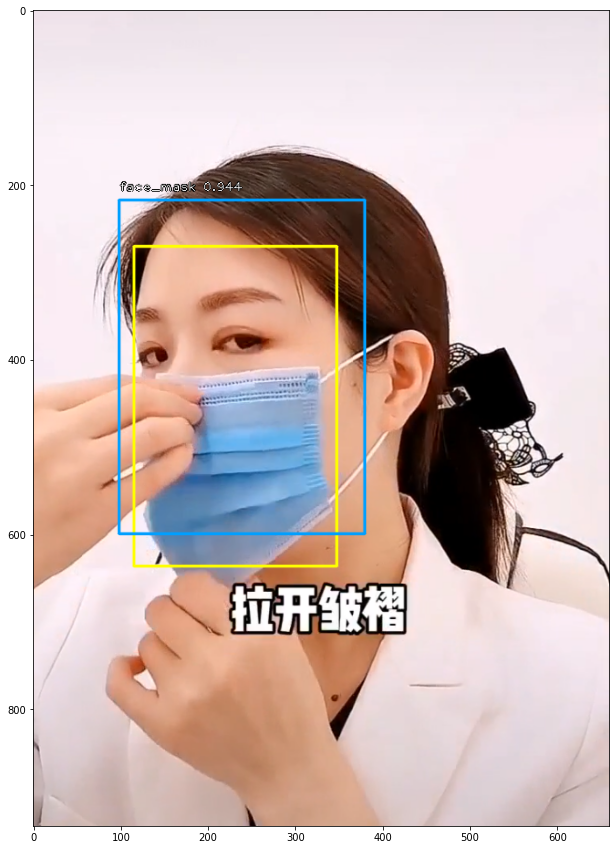

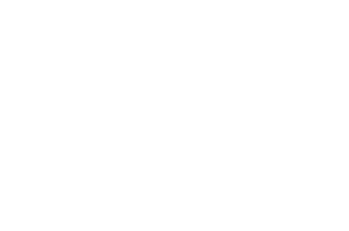

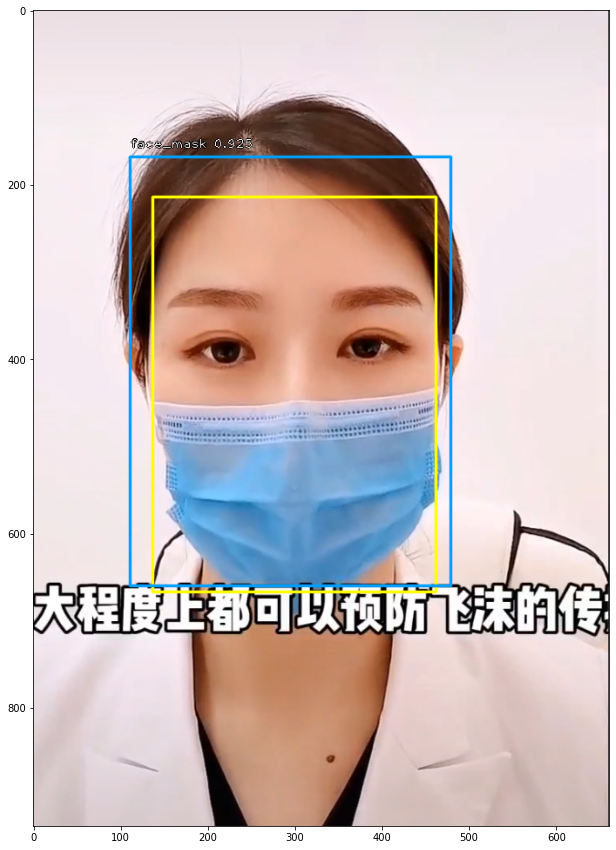

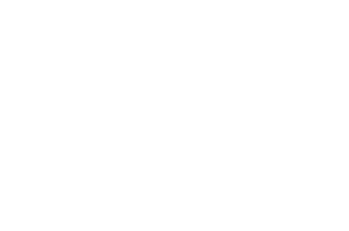

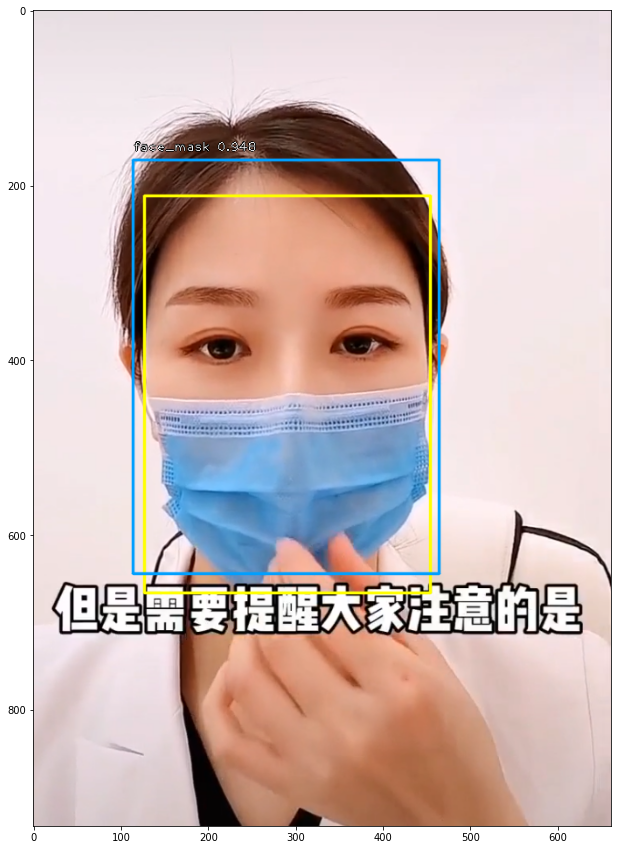

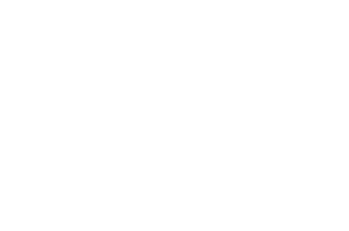

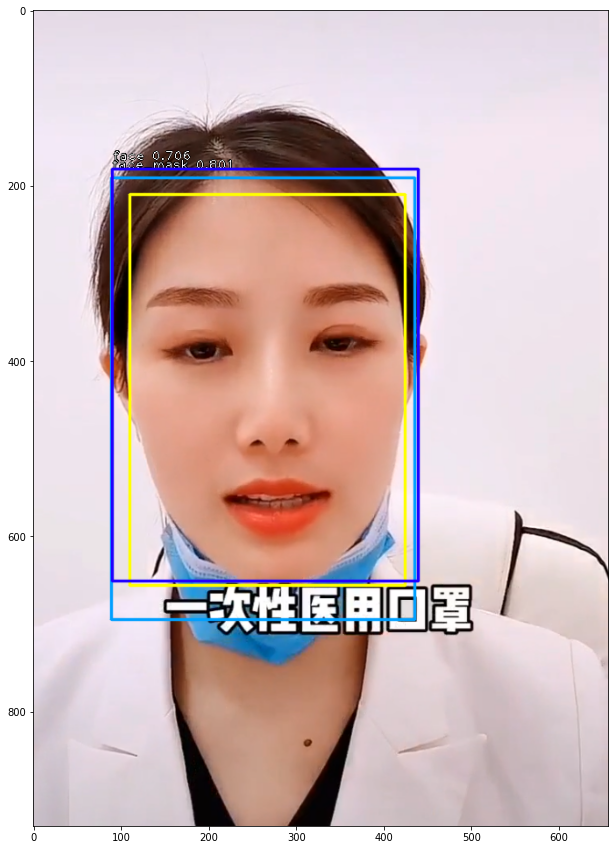

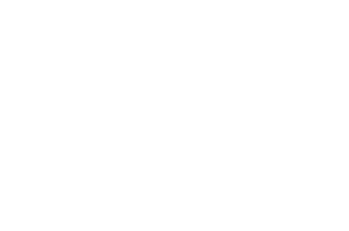

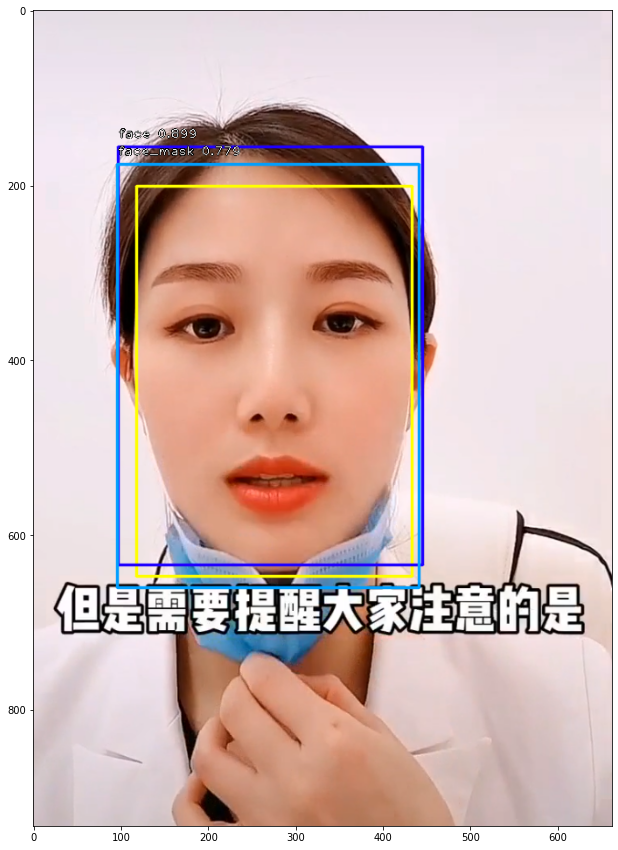

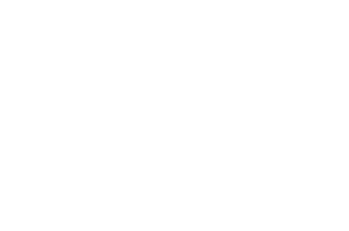

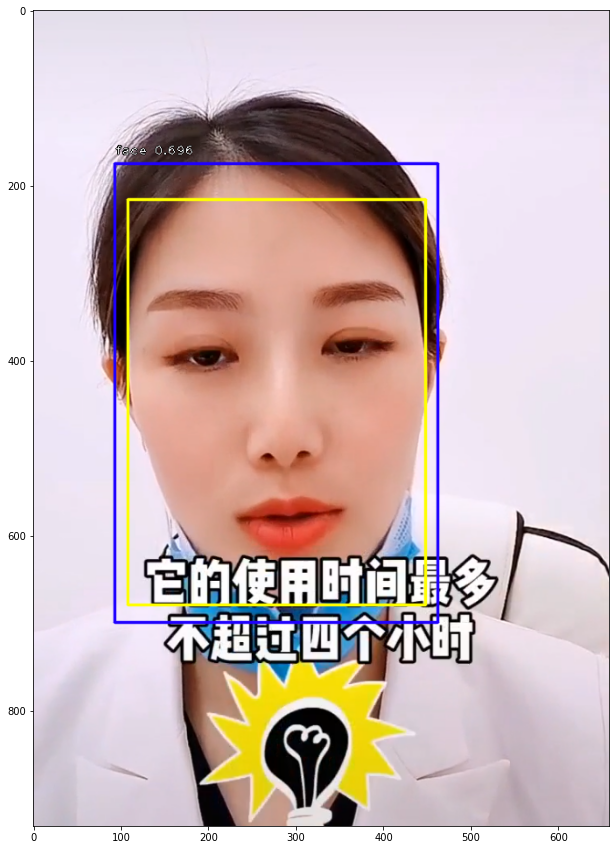

In [30]:
for i in range (12):
  show_detected_objects(test_df.iloc[i])
  test_df.iloc[i]